# Sentiment Analysis of Donesi.com Reviews

In [1]:
# imports
import pandas as pd
from nltk.tokenize import RegexpTokenizer
import serbian_stemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

List of stopwords downloaded from http://nlp.ffzg.hr/ and adjusted to fully support Serbian language.

In [2]:
# loading stopwrods
f = open("../data/stopwords.txt")
lines = f.readlines()
f.close()
stopwords = []
for line in lines:
    if line.endswith('\n'):
        line = line[:-1]
    stopwords.append(line)  

Pipeline:  
- Replacing emoticons and interpunction  
- Tokenization  
- Removing stopwords  
- Skipping empty reviews  
- Stemming

In [3]:
reviews = []
sentiments = []

# loading data
df = pd.read_excel("../data/reviews.xlsx")
for index, row in df.iterrows():
    review = row['Title'] + ' ' + row['Content']
    review = review.lower()
    rating = float(row['Rating'])
    sentiment = 0
    if rating >= 3.5:
        sentiment = 1
        
    # replacing emoticons and interpunction
    review = review.replace(";]", " ok ")
    review = review.replace(";-)", " ok ")
    review = review.replace(";)", " ok ")
            
    review = review.replace(":-))", " veoma odlican ")
    review = review.replace("=3", " veoma odlican ")
            
    review = review.replace(":]", " odlican ")
    review = review.replace("=]", " odlican ")
    review = review.replace(":3", " odlican ")
    review = review.replace("=)", " odlican ")
    review = review.replace(":)", " odlican ")
    review = review.replace(":-)", " odlican ")
            
    review = review.replace(":o", " iznenadjen ")
    review = review.replace("o.o", " iznenadjen ")
            
    review = review.replace(":(", " lose ")
    review = review.replace(":@", " lose ")
    review = review.replace(":-(", " lose ")
    review = review.replace(":-/", " lose ")
    review = review.replace(":/", " lose ")
            
    review = review.replace(":'(", " veoma lose ")
            
    review = review.replace(":|", " neodlucan ")
    review = review.replace(":-|", " neodlucan ")
            
    review = review.replace(":*", " lepo ")
    review = review.replace(":-*", " lepo ")
            
    review = review.replace("+", " plus ")
    review = review.replace("-", " minus ")
    review = review.replace("!", " veoma ")
    
    # tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    review_words = tokenizer.tokenize(review)
    
    # removing stopwords
    new_review_words = []
    for word in review_words:
        if word not in stopwords:
            new_review_words.append(word)
    
    # skip empty reviews
    new_review = ' '.join(new_review_words)
    if new_review != ' ' and new_review != '':
        # stemming
        stemmed_review = serbian_stemmer.stem(new_review)
        # preparing data for Pandas dataframe
        reviews.append(stemmed_review)
        sentiments.append(sentiment)

# creating new Pandas dataframe
new_data = {"review": reviews, "sentiment": sentiments}
data = pd.DataFrame.from_dict(new_data)
print(data.head(10))
print("\n")
print(data.info())
print("\n")
print(data.describe())

                                              review  sentiment
0                   odlicn brz kvalitetn ukusn veom           1
1  velik cevap velik cevap kajmak cijen solidn ce...          1
2  odlicn krompir madjarsk corb odlicn krompir co...          0
3          v cevap cevap kajmak dodj luk iznenadjen           1
4                           kasnjenj narudzbin kasn           0
5  punjen pljeskavic naruci punjen pljeskavic pro...          0
6          brav brzin dostav zavidn nivo hran ukusn           1
7  velik cevap pomfri cevap pristojn ukus ukus os...          1
8         odlicn hran dostav dogovoren vremen pohva           1
9                extr stiga rekl rol raznjic odlicn           1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64799 entries, 0 to 64798
Data columns (total 2 columns):
review       64799 non-null object
sentiment    64799 non-null int64
dtypes: int64(1), object(1)
memory usage: 1012.6+ KB
None


          sentiment
count  64799.000000
mean       0.8233

Displaying word clouds after pipeline.

In [4]:
def generate_word_cloud(input_text):
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(input_text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


Positive reviews



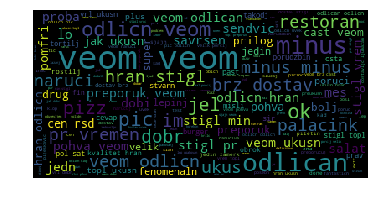


Negative reviews



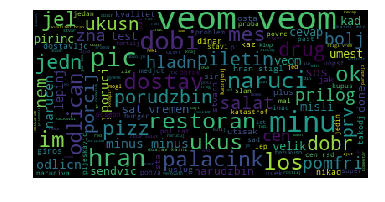


All reviews



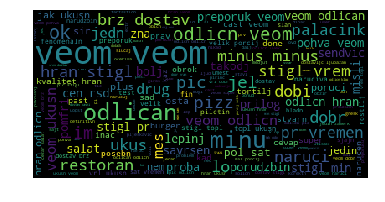

In [5]:
print("\nPositive reviews\n")
pos_rev = data.loc[data['sentiment'] == 1]
pos_text = ' '.join(pos_rev['review'])
generate_word_cloud(pos_text)

print("\nNegative reviews\n")
neg_rev = data.loc[data['sentiment'] == 0]
neg_text = ' '.join(neg_rev['review'])
generate_word_cloud(neg_text)

print("\nAll reviews\n")
rev_text = ' '.join(data['review'])
generate_word_cloud(rev_text)

Vectorization and Classification

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

Trying out: 80% - 20% random split with TF-IDF and Count (bigrams) vectorization and SVM with Linear kernel.

In [17]:
# 80-20 random split
x = data['review']
y = data['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# TF-IDF vectorization
tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(x_train)
tfidf_test = tfidf.transform(x_test)
# Bigrams
bigram = CountVectorizer(ngram_range=(1, 2))
bigram_train = bigram.fit_transform(x_train)
bigram_test = bigram.transform(x_test)
# Linear SVC classifier 
print("\nLinear SVC + TF-IDF\n")
tfidf_class = LinearSVC()
tfidf_class.fit(tfidf_train, y_train)
y_pred = tfidf_class.predict(tfidf_test)
print(classification_report(y_test, y_pred))

print("\nLinear SVC + Bigrams\n")
bigram_class = LinearSVC()
bigram_class.fit(bigram_train, y_train)
y_pred = bigram_class.predict(bigram_test)
print(classification_report(y_test, y_pred))


Linear SVC + TF-IDF

             precision    recall  f1-score   support

          0       0.74      0.57      0.64      2326
          1       0.91      0.96      0.93     10634

avg / total       0.88      0.89      0.88     12960


Linear SVC + Bigrams

             precision    recall  f1-score   support

          0       0.70      0.59      0.64      2326
          1       0.91      0.94      0.93     10634

avg / total       0.87      0.88      0.88     12960



Trying out Stratified Shuffle Split (5 folds, 80%-20% ratio) with TF-IDF and Count (bigrams) vectorization and SVM with Linear kernel.

In [20]:
x = data['review']
y = data['sentiment']

# split
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(x, y)
print("\nLinear SVC + TF-IDF\n")
for train_index, test_index in sss.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # tf-idf
    tfidf = TfidfVectorizer()
    tfidf_train = tfidf.fit_transform(x_train)
    tfidf_test = tfidf.transform(x_test)
    # classification
    tfidf_class = LinearSVC()
    tfidf_class.fit(tfidf_train, y_train)
    y_pred = tfidf_class.predict(tfidf_test)
    print(classification_report(y_test, y_pred))
    
print("\n\nLinear SVC + Bigrams\n")
for train_index, test_index in sss.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # bigrams
    bigram = CountVectorizer(ngram_range=(1, 2))
    bigram_train = bigram.fit_transform(x_train)
    bigram_test = bigram.transform(x_test)
    # classification
    bigram_class = LinearSVC()
    bigram_class.fit(bigram_train, y_train)
    y_pred = bigram_class.predict(bigram_test)
    print(classification_report(y_test, y_pred))


Linear SVC + TF-IDF

             precision    recall  f1-score   support

          0       0.76      0.58      0.66      2289
          1       0.91      0.96      0.94     10671

avg / total       0.89      0.89      0.89     12960

             precision    recall  f1-score   support

          0       0.74      0.58      0.65      2289
          1       0.91      0.96      0.93     10671

avg / total       0.88      0.89      0.88     12960

             precision    recall  f1-score   support

          0       0.76      0.57      0.65      2289
          1       0.91      0.96      0.94     10671

avg / total       0.88      0.89      0.88     12960

             precision    recall  f1-score   support

          0       0.76      0.60      0.67      2289
          1       0.92      0.96      0.94     10671

avg / total       0.89      0.90      0.89     12960

             precision    recall  f1-score   support

          0       0.75      0.57      0.65      2289
          1